In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from Electron_trajectories_OO import QSA_PWFA

In [2]:
# Beam 
n_b = 5
R_b = 0.1

ksi0 = 3
R_xi = 1

Nr_loc = 64

N_xi = 15000

calc = QSA_PWFA(L_xi=20, N_xi=N_xi, L_r=20*R_b, N_r=128)

calc.init_bunch(n_b, R_b, ksi0, R_xi)


for i_xi in range(N_xi):
    calc.xi_step(i_xi)
    calc.r_xi[i_xi] = calc.r

<IPython.core.display.Javascript object>


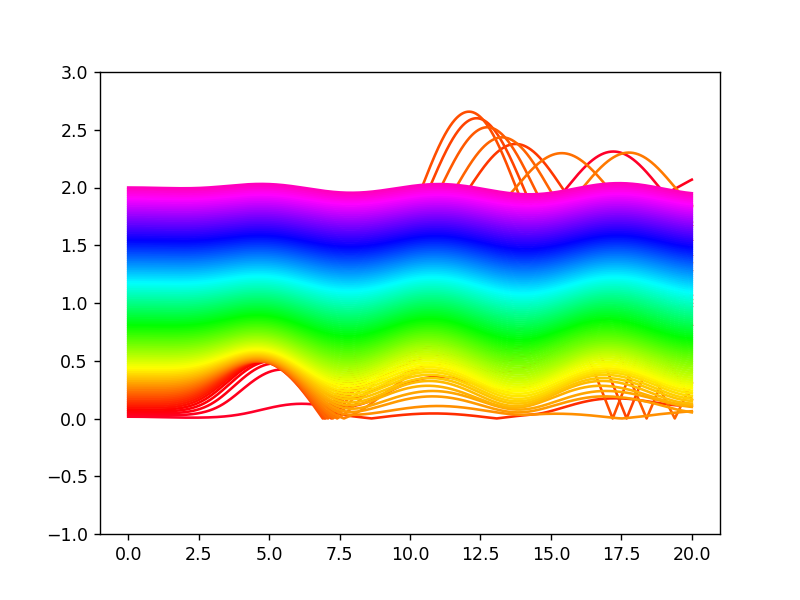

(-1, 3)

In [3]:
plt.figure()


for j in range(calc.N_r):
    plt.plot(calc.xi, calc.r_xi[:, j], color=calc.rainbow(j/calc.N_r))
    
plt.ylim(-1, 3)

## Input parameters

In [99]:
# Beam 
n_b = 5
R_b = 0.1
ksi0 = 3
R_xi = 1

# Simulation domain 
L_xi = 20
N_steps = 15000

rmax = 20 * R_b
N_rings = 128
Nr_loc = 64

# Make grids
xi = L_xi / N_steps * np.arange(N_steps)
r0 = np.linspace(rmax/N_rings, rmax, N_rings)

# Miscellaneous
rainbow = matplotlib.cm.get_cmap('gist_rainbow', N_rings)

In [21]:
def init_condition(N_steps, N_rings, r0):
    """
    Allocate solution array and set initial conditions
    """
    r = np.zeros((N_steps, N_rings))  
    r[0, :] = r0
    r[1, :] = r0
    return r

@njit
def gaussian_beam(r, ksi, n_b, R_b, R_xi, ksi0):
    """
    Gaussian beam density distribution
    """
    val = n_b * np.exp(-(ksi-ksi0)**2 / 2 / R_xi**2 ) \
        * np.exp(-r**2 / (2 * R_b**2))
        
    return val

@njit
def gaussian_integrate(r, ksi, n_b, R_b, R_xi, ksi0):
    """
    Gaussian beam density distribution integrated over `r`
    """    
    val = n_b * np.exp(-(ksi-ksi0)**2 / 2 / R_xi**2) \
        * R_b**2 * ( 1 - np.exp(-r**2 / 2 / R_b**2 ) )
    return val

In [22]:
@njit
def cross_integrator_precalc_abs(r, xi, n_b, R_b, R_xi, ksi0):
    
    N_steps, N_rings  = r.shape    
    dxi = xi[1] - xi[0]    
    r0 = r[0, :]
    dr = r0[1] - r0[0]
    
    for i in range(1, N_steps-1):
        r_i = r[i]
        r_im1 = r[i-1]        
        xi_i = xi[i]
        
        for j in range(N_rings):

            integral_nb_dr = gaussian_integrate(r_i[j], xi_i, n_b, R_b, R_xi, ksi0)
            
            integral_plasma = 0.0
            for l in range(N_rings): 
                if (r_i[l]<=r_i[j]) and (l!=j):
                    integral_plasma += r0[l] * dr            

            r[i+1, j] = -r_im1[j] + (2 - 0.5*dxi**2) * r_i[j] +  dxi**2 / r_im1[j] * \
                ( integral_plasma + integral_nb_dr )
            
            r[i+1, j] = np.abs(r[i+1, j])
                        
    return r


@njit
def cross_integrator_abs(r, xi, n_b, R_b, R_xi, ksi0):
    
    N_steps, N_rings  = r.shape    
    dxi = xi[1] - xi[0]    
    r0 = r[0, :]
    dr = r0[1] - r0[0]
    
    for i in range(1, N_steps-1):
        r_i = r[i]
        r_im1 = r[i-1]        
        xi_i = xi[i]
        
        for j in range(N_rings):

            r_loc = np.linspace(0, r_i[j], Nr_loc)
            dr_loc = r_loc[1] - r_loc[0]            
            integral_nb_dr = dr_loc * (r_loc * gaussian_beam(r_loc, xi_i, n_b, R_b, R_xi, ksi0)).sum()
            
            integral_plasma = 0.0
            for l in range(N_rings): 
                if (r_i[l]<=r_i[j]) and (l!=j):
                    integral_plasma += r0[l] * dr            

            r[i+1, j] = -r_im1[j] + (2 - 0.5*dxi**2) * r_i[j] +  dxi**2 / r_im1[j] * \
                ( integral_plasma + integral_nb_dr )
            
            r[i+1, j] = np.abs(r[i+1, j])
                        
    return r

@njit
def no_cross_integrator_precalc_abs(r, xi, n_b, R_b, R_xi, ksi0):
    
    N_steps, N_rings  = r.shape    
    dxi = xi[1] - xi[0]    
    r0 = r[0, :]
    
    for i in range(1, N_steps-1):
        r_i = r[i]
        r_im1 = r[i-1]        
        xi_i = xi[i]
        
        for j in range(N_rings):

            integral_nb_dr = gaussian_integrate(r_i[j], xi_i, n_b, R_b, R_xi, ksi0)

            r[i+1, j] = -r_im1[j] + (2 - 0.5*dxi**2) * r_i[j] +  dxi**2 / r_im1[j] * \
                ( 0.5*r0[j]**2 + integral_nb_dr )
            
            r[i+1, j] = np.abs(r[i+1, j])
            
    return r

@njit
def no_cross_integrator(r, xi, n_b, R_b, R_xi, ksi0):
    
    N_steps, N_rings  = r.shape    
    dxi = xi[1] - xi[0]    
    r0 = r[0, :]
    dr = r0[1] - r0[0]
    
    for i in range(1, N_steps-1):
        r_i = r[i]
        r_im1 = r[i-1]        
        xi_i = xi[i]
        
        for j in range(N_rings):
            
            r_loc = np.linspace(0, r_i[j], Nr_loc)
            dr_loc = r_loc[1] - r_loc[0]            
            integral_nb_dr = dr_loc * (r_loc * gaussian_beam(r_loc, xi_i, n_b, R_b, R_xi, ksi0)).sum()
            
            r[i+1, j] = -r_im1[j] + (2 - 0.5*dxi**2) * r_i[j] +  dxi**2 / r_im1[j] * \
                ( 0.5*r0[j]**2 + integral_nb_dr )
            
            r[i+1, j] = np.abs(r[i+1, j])
            
    return r

In [107]:
@njit
def lower_order_system_abs_r(r, r_deriv, xi, n_b, R_b, R_xi, ksi0):
    
    N_steps, N_rings  = r.shape    
    dxi = xi[1] - xi[0]    
    r0 = r[0, :]
    dr = r0[1] - r0[0]
    
    for i in range(1, N_steps-1):
        r_i = r[i]
        r_im1 = r[i-1]   
        r_deriv_i = r_deriv[i]
        r_deriv_im1 = r_deriv[i-1]
        xi_i = xi[i]
        
        for j in range(N_rings):

            integral_nb_dr = gaussian_integrate(r_i[j], xi_i, n_b, R_b, R_xi, ksi0)
            
            integral_plasma = 0.0
            for l in range(N_rings): 
                if (r_i[l]<=r_i[j]) and (l!=j):
                    integral_plasma += r0[l] * dr  
                    
            #r_deriv[i+1, j] = r_deriv_im1[j] - 0.5*dxi*r_im1[j] + dxi / r_im1[j]* \
                #( integral_plasma + integral_nb_dr )
            
            #r[i+1, j] = r_im1[j] + dxi*r_deriv_im1[j]
            
            
                     
            r_deriv[i+1, j] = r_deriv_i[j] - 0.5*dxi*r_i[j] + dxi / r_i[j]* \
                ( integral_plasma + integral_nb_dr )
            
            r[i+1, j] = r_i[j] + dxi*r_deriv_i[j]
            
        
            
            r[i+1, j] = np.abs(r[i+1, j])
                        
    return r, r_deriv


@njit
def lower_order_system_abs_r_deriv(r, r_deriv, xi, n_b, R_b, R_xi, ksi0):
    
    N_steps, N_rings  = r.shape    
    dxi = xi[1] - xi[0]    
    r0 = r[0, :]
    dr = r0[1] - r0[0]
    
    for i in range(1, N_steps-1):
        r_i = r[i]
        r_im1 = r[i-1]   
        r_deriv_i = r_deriv[i]
        r_deriv_im1 = r_deriv[i-1]
        xi_i = xi[i]
        
        for j in range(N_rings):

            integral_nb_dr = gaussian_integrate(r_i[j], xi_i, n_b, R_b, R_xi, ksi0)
            
            integral_plasma = 0.0
            for l in range(N_rings): 
                if (r_i[l]<=r_i[j]) and (l!=j):
                    integral_plasma += r0[l] * dr  
                    
            #r_deriv[i+1, j] = r_deriv_im1[j] - 0.5*dxi*r_im1[j] + dxi / r_im1[j]* \
                #( integral_plasma + integral_nb_dr )
            
            #r[i+1, j] = r_im1[j] + dxi*r_deriv_im1[j]
            
            r_deriv[i+1, j] = r_deriv_i[j] - 0.5*dxi*r_i[j] + dxi / r_i[j]* \
                ( integral_plasma + integral_nb_dr )
            
            r[i+1, j] = r_i[j] + dxi*r_deriv_i[j]
        
            
            
            if r[i+1, j] < 0:
                r_deriv[i+1, j] = np.abs(r_deriv[i+1, j])
                r[i+1, j] = np.abs(r[i+1, j])
                        
    return r, r_deriv

<IPython.core.display.Javascript object>


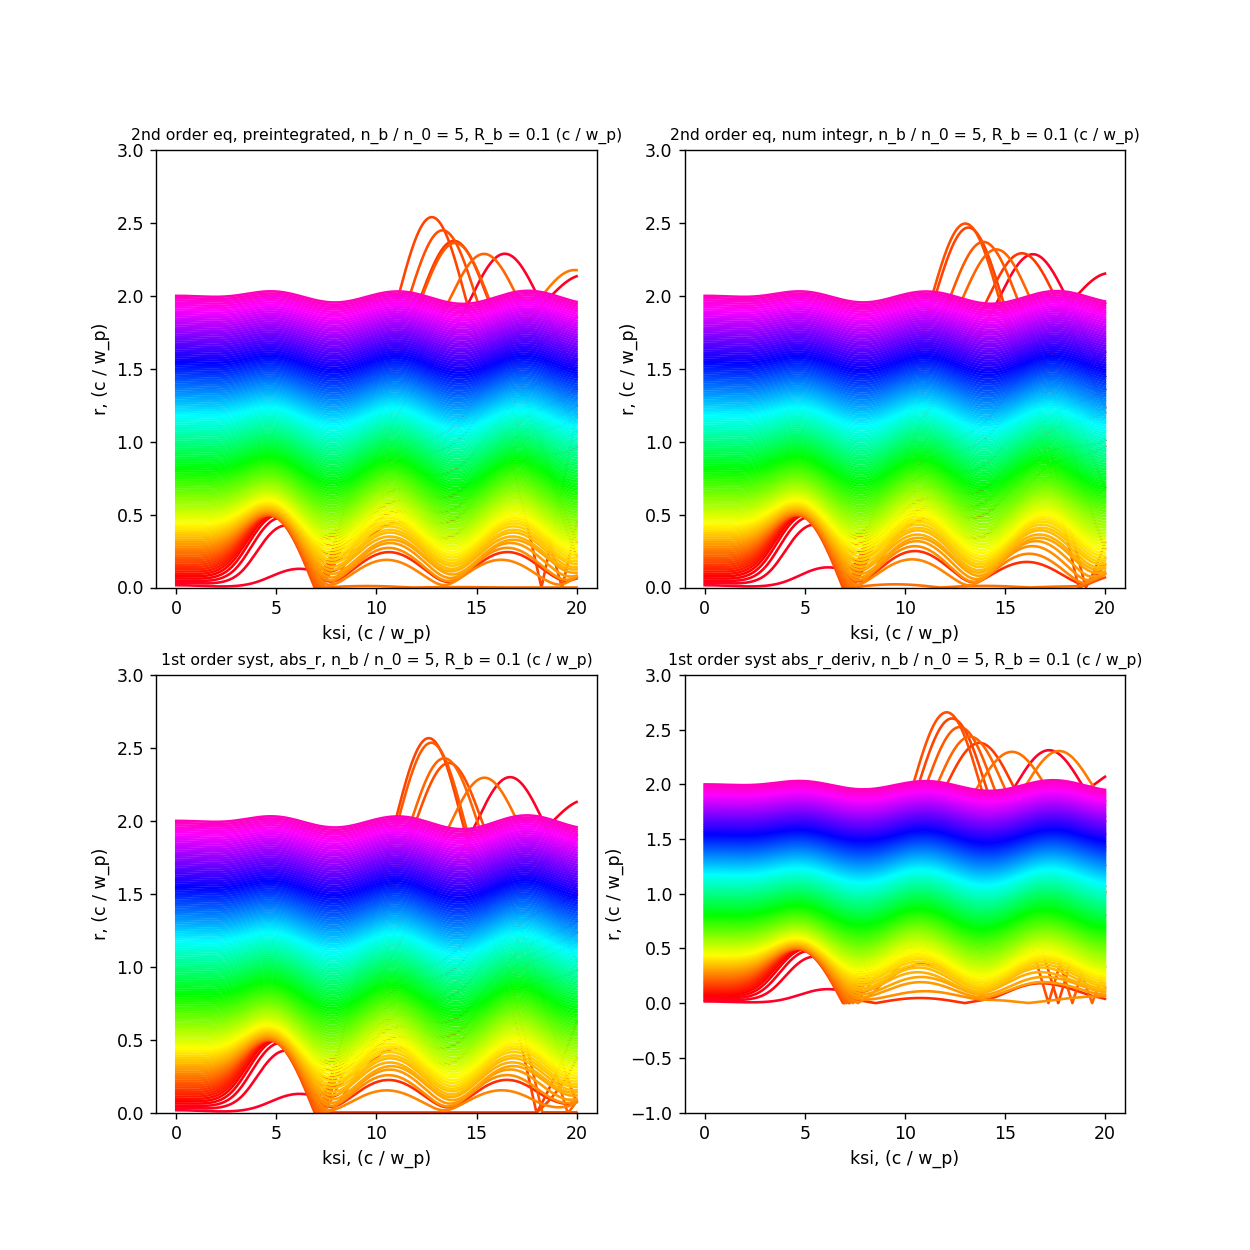

In [108]:
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
plt.figure(figsize=(10,10))

##
plt.subplot(221)
r = init_condition(N_steps, N_rings, r0)
r = cross_integrator_precalc_abs(r, xi, n_b, R_b, R_xi, ksi0)
for j in range(N_rings):
    plt.plot(xi, r[:, j], color=rainbow(j/N_rings))
    
plt.xlabel('ksi, (c / w_p)')
plt.ylabel('r, (c / w_p)')
plt.title('2nd order eq, preintegrated, ''n_b / n_0 = '+str(n_b)+', R_b = '+str(R_b)+' (c / w_p)', fontsize=9)
plt.ylim(0, 3)


##
plt.subplot(222)
r = init_condition(N_steps, N_rings, r0)
r = cross_integrator_abs(r, xi, n_b, R_b, R_xi, ksi0)

for j in range(N_rings):
    plt.plot(xi, np.abs(r[:, j]), color=rainbow(j/N_rings))
    
plt.xlabel('ksi, (c / w_p)')
plt.ylabel('r, (c / w_p)')
plt.title('2nd order eq, num integr, ''n_b / n_0 = '+str(n_b)+', R_b = '+str(R_b)+' (c / w_p)', fontsize=9)
plt.ylim(0, 3)

##
plt.subplot(223)
r = init_condition(N_steps, N_rings, r0)
r_deriv = init_condition(N_steps, N_rings, 0)

r, r_deriv = lower_order_system_abs_r(r, r_deriv, xi, n_b, R_b, R_xi, ksi0)

for j in range(N_rings):
    plt.plot(xi, r[:, j], color=rainbow(j/N_rings))
    
plt.xlabel('ksi, (c / w_p)')
plt.ylabel('r, (c / w_p)')
plt.title('1st order syst, abs_r, ''n_b / n_0 = '+str(n_b)+', R_b = '+str(R_b)+' (c / w_p)', fontsize=9)
plt.ylim(0, 3)

##
plt.subplot(224)
r = init_condition(N_steps, N_rings, r0)
r_deriv = init_condition(N_steps, N_rings, 0)

r, r_deriv = lower_order_system_abs_r_deriv(r, r_deriv, xi, n_b, R_b, R_xi, ksi0)

for j in range(N_rings):
    plt.plot(xi, r[:, j], color=rainbow(j/N_rings))
    
plt.xlabel('ksi, (c / w_p)')
plt.ylabel('r, (c / w_p)')
plt.title('1st order syst abs_r_deriv, ''n_b / n_0 = '+str(n_b)+', R_b = '+str(R_b)+' (c / w_p)', fontsize=9)
plt.ylim(-1, 3)

plt.show()

In [71]:
L_xi/30000

0.0006666666666666666

<IPython.core.display.Javascript object>


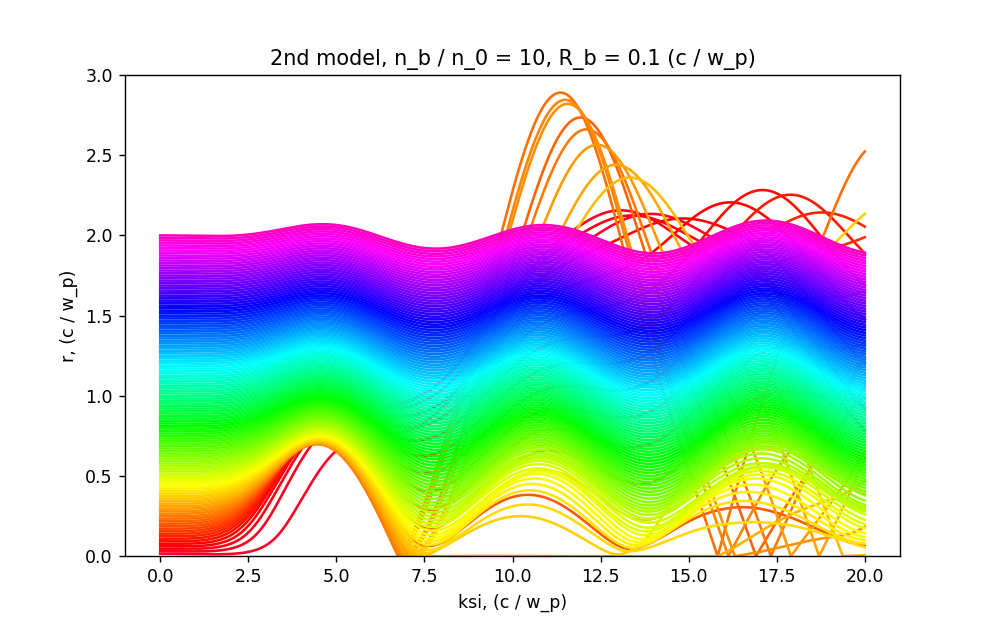

<IPython.core.display.Javascript object>


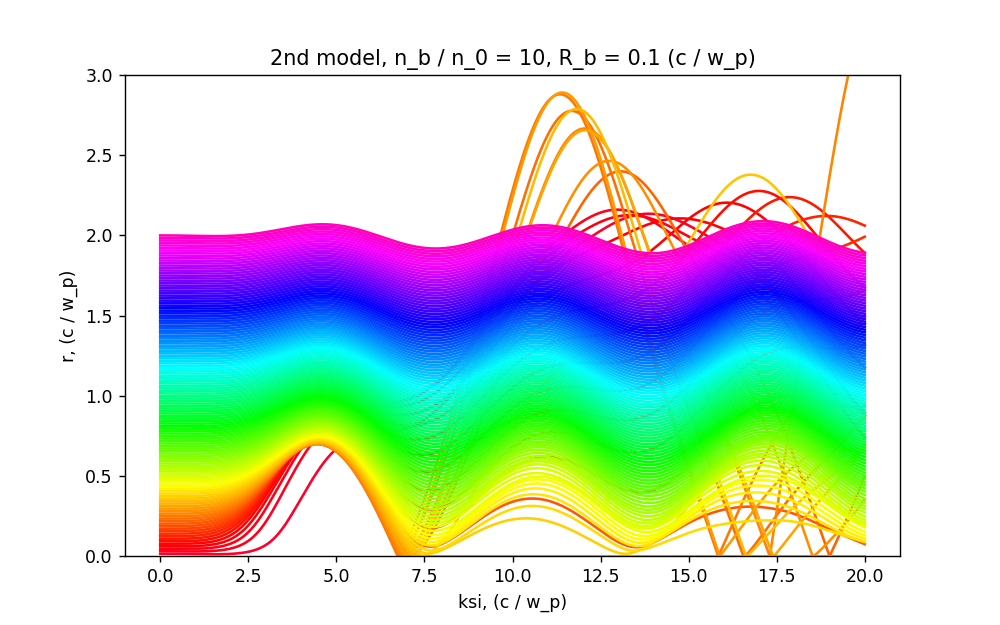

<IPython.core.display.Javascript object>


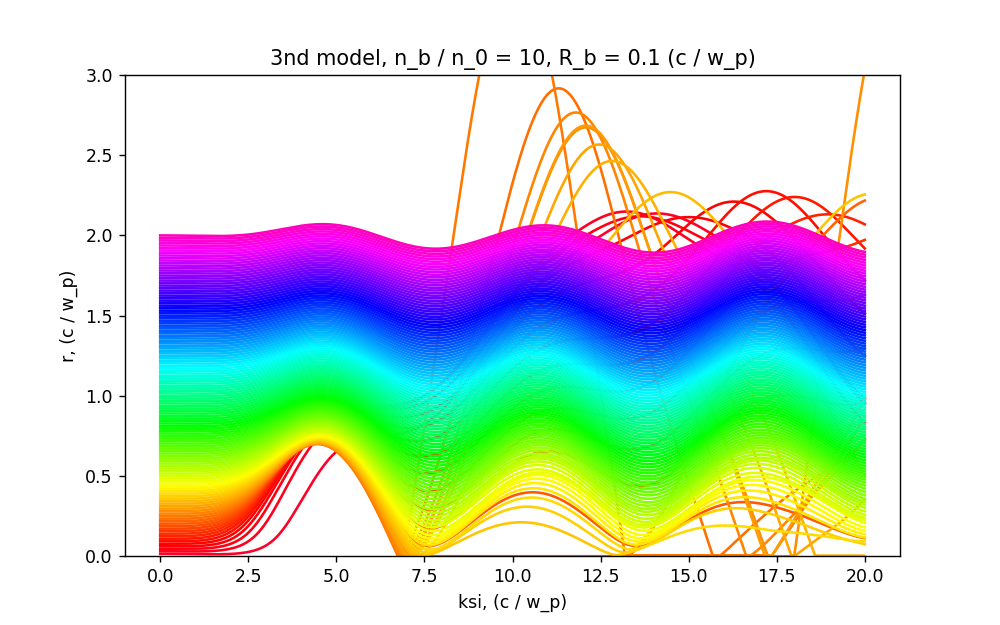

<IPython.core.display.Javascript object>


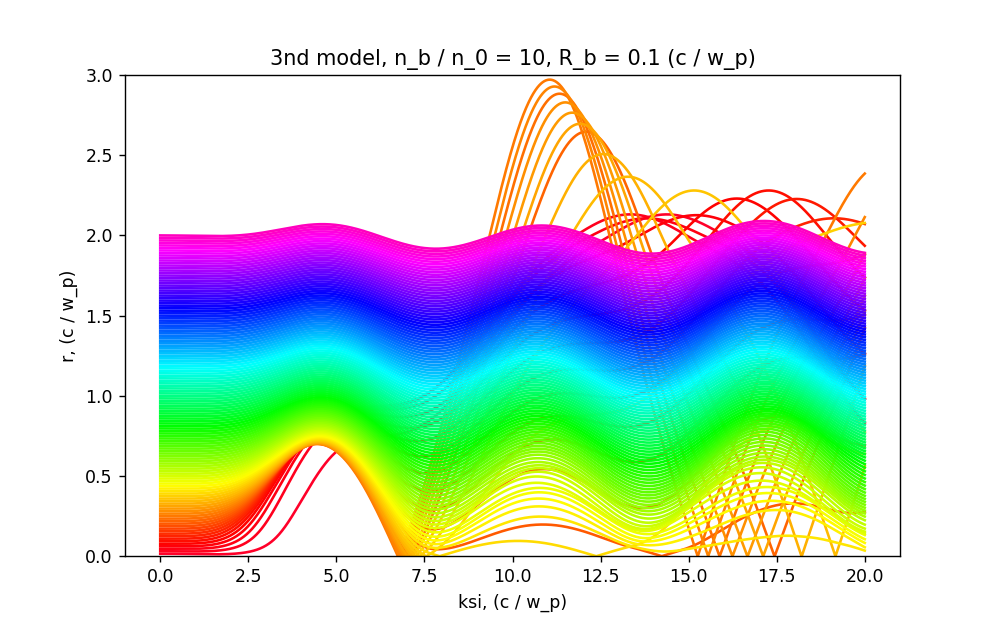

(0, 3)

In [24]:
r = init_condition(N_steps, N_rings, r0)
r = cross_integrator_precalc_abs(r, xi, n_b, R_b, R_xi, ksi0)

plt.figure(figsize=(8,5))

for j in range(N_rings):
    plt.plot(xi, r[:, j], color=rainbow(j/N_rings))
    
plt.xlabel('ksi, (c / w_p)')
plt.ylabel('r, (c / w_p)')
plt.title('2nd model, ''n_b / n_0 = '+str(n_b)+', R_b = '+str(R_b)+' (c / w_p)')
plt.ylim(0, 3)

##

r = init_condition(N_steps, N_rings, r0)
r = cross_integrator_abs(r, xi, n_b, R_b, R_xi, ksi0)

plt.figure(figsize=(8,5))

for j in range(N_rings):
    plt.plot(xi, np.abs(r[:, j]), color=rainbow(j/N_rings))
    
plt.xlabel('ksi, (c / w_p)')
plt.ylabel('r, (c / w_p)')
plt.title('2nd model, ''n_b / n_0 = '+str(n_b)+', R_b = '+str(R_b)+' (c / w_p)')
plt.ylim(0, 3)

##
r = init_condition(N_steps, N_rings, r0)
r_deriv = init_condition(N_steps, N_rings, 0)

r, r_deriv = lower_order_system_abs_r(r, r_deriv, xi, n_b, R_b, R_xi, ksi0)

plt.figure(figsize=(8,5))

for j in range(N_rings):
    plt.plot(xi, r[:, j], color=rainbow(j/N_rings))
    
plt.xlabel('ksi, (c / w_p)')
plt.ylabel('r, (c / w_p)')
plt.title('3nd model, ''n_b / n_0 = '+str(n_b)+', R_b = '+str(R_b)+' (c / w_p)')
plt.ylim(0, 3)


##
r = init_condition(N_steps, N_rings, r0)
r_deriv = init_condition(N_steps, N_rings, 0)

r, r_deriv = lower_order_system_abs_r_deriv(r, r_deriv, xi, n_b, R_b, R_xi, ksi0)

plt.figure(figsize=(8,5))

for j in range(N_rings):
    plt.plot(xi, r[:, j], color=rainbow(j/N_rings))
    
plt.xlabel('ksi, (c / w_p)')
plt.ylabel('r, (c / w_p)')
plt.title('3nd model, ''n_b / n_0 = '+str(n_b)+', R_b = '+str(R_b)+' (c / w_p)')
plt.ylim(0, 3)

In [ ]:
#  r'(ksi) = r_deriv(ksi)
#  r_deriv'(ksi) = -b*r(ksi) - c/r(ksi)

def system(r,r_deriv,ksi, b, c):
    y = r, r_deriv
    dydxi = [r_deriv, -b*r - c/r]
    return dydxi

In [ ]:
def solve_system(system_i, system_0, xi):
    sol = odeint(system_i, system_0, xi, args=(b, c))
    return sol

In [ ]:
r = init_condition(N_steps, N_rings, r0)
r = solve_system(r, xi, n_b, R_b, R_xi, ksi0)

In [ ]:
N_steps, N_rings  = r.shape    
    dxi = xi[1] - xi[0]    
    r0 = r[0, :]
    dr = r0[1] - r0[0]
    r_deriv = np.zeros((N_steps, N_rings))
    
    for i in range(1, N_steps-1):
        r_i = r[i]
        r_im1 = r[i-1]  
        r_deriv_i = r_deriv[i]
        r_deriv_im1 = r_deriv[i-1]
        xi_i = xi[i]
        
        
        for j in range(N_rings):

            b = 0.5

            integral_plasma = 0.0
                
                for l in range(N_rings): 
                    if (r_i[l]<=r_i[j]) and (l!=j):
                        integral_plasma += r0[l] * dr            


            integral_nb_dr = gaussian_integrate(r_i[j], xi_i, n_b, R_b, R_xi, ksi0)

            c = -(integral_plasma + integral_nb_dr)

            if i == 1:
                system_im1 = [r0, 0]
            else:
                system_im1 = [r_im1, n_im1]
